In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

# Running functions_bar_igw.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/OSSE_borrador/IGW_BAR/functions_bar_igw.ipynb

In [2]:
path_to_mask = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc" # in numpy .npy format
path_to_input = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_" # including the file name prefix 
path_to_save = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_bar/" # including the file name prefix 

# Loading ssh_hf and making and selecting 1h for testing
ssh_hf = xr.open_mfdataset(path_to_input + "01.nc")
ds = ssh_hf.rename({'__xarray_dataarray_variable__': 'ssh_hf'}).sel(time_counter=pd.to_datetime('2014-01-10T00:30:00')).load()

# Loading Mask
mask = xr.open_dataset(path_to_mask,drop_variables={"x","y"}) 
mask = mask.tmaskutil[0,:,:].values

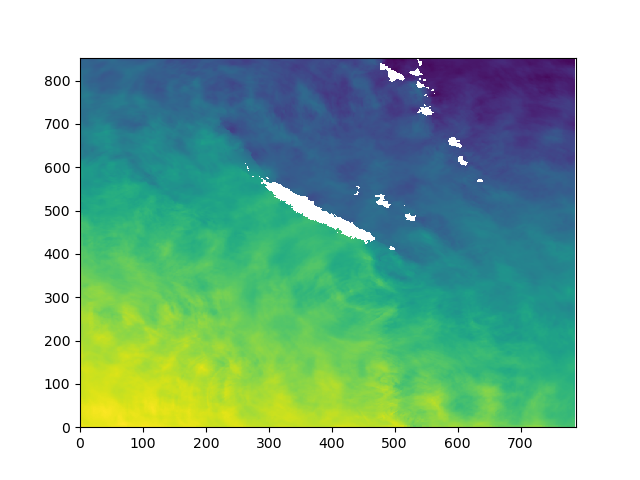

In [3]:
ssh_hf_a = xr.open_mfdataset(path_to_input + "12.nc")
ds_a = ssh_hf_a.rename({'__xarray_dataarray_variable__': 'ssh_hf'}).sel(time_counter=pd.to_datetime('2014-12-29T03:30:00')).load()

plt.figure()
plt.pcolormesh(ds_a.ssh_hf)
plt.show()

Mask, Coarsen, axis, grid2D and filled

In [4]:
ssh_hf = ds.ssh_hf.where(mask==1,np.nan) # change false by 1, otherwise everithing is nan
# print('mask: ok')

ssh_hf = ssh_hf.coarsen(x=4, y=4, boundary='trim').mean()
# print('coarsen: ok')

x_axis = Axis(ssh_hf.x.values,is_circle=True)
y_axis = Axis(ssh_hf.y.values,is_circle=True)
# print('x_axis,y_axis: ok') # t_axis no longer needed    

grid = Grid2D(y_axis, x_axis, ssh_hf.values.transpose(0,1))
# print('grid: ok') 

has_converged, filled = fill.gauss_seidel(grid) # we do not need to transpose, cause we are not concern by t_axis
#print('convergence =', has_converged)
# print('filled: ok')

ssh_hf_filled = ssh_hf.copy(deep=True,data=filled) # is it ok?
# print('copy: ok')

To cartesian grid

In [5]:
dx = 10 # in kilometers

ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(ssh_hf_filled.lat[:,0].values,
                                                            ssh_hf_filled.lon[0,:].values,
                                                            dx)
  

In [6]:
# Create a new DataArray with the filled data
ssh_hf_filled = xr.DataArray(
    data=filled,
    dims=['y', 'x'],
    coords={'y': ssh_hf.y, 'x': ssh_hf.x, 'lat': (['y', 'x'], ssh_hf.lat.data), 'lon': (['y', 'x'], ssh_hf.lon.data)}
)

dx = 10  # in kilometers

ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(ssh_hf_filled.lat[:, 0].values,
                                                         ssh_hf_filled.lon[0, :].values,
                                                         dx)

ENSLAT2D_flat = ENSLAT2D.flatten()
ENSLON2D_flat = ENSLON2D.flatten()

points = np.column_stack((ssh_hf_filled.lat.data.flatten(), ssh_hf_filled.lon.data.flatten()))
values = ssh_hf_filled.data.flatten()
target_grid = np.column_stack((ENSLAT2D_flat, ENSLON2D_flat))

array_cart_ssh = griddata(points, values, target_grid, method='linear')

array_cart_ssh = array_cart_ssh.reshape(ENSLAT2D.shape)

In [7]:
#INTERPOLATION OF NaNs # 
x_axis = Axis(np.arange(i_lon))
y_axis = Axis(np.arange(i_lat))
    
grid = Grid2D(y_axis, x_axis, array_cart_ssh.reshape((i_lat,i_lon)))
has_converged, filled = fill.gauss_seidel(grid)

mask_cart = np.isnan(array_cart_ssh.reshape((i_lat,i_lon)))

cart_ssh_hf = xr.DataArray(data=filled,
                            dims=["y","x"],
                            coords = dict(
                                y=(["y"],np.arange(i_lat)),
                                x=(["x"],np.arange(i_lon))
                            ))

In [8]:
# EXTRACTING BAROTROPIC TIDE # 
cart_ssh_filtered = np.array(extract_bar_tide(cart_ssh_hf.values, dx))

In [9]:
#lon2d, lat2d = np.meshgrid(ssh_hf.lon.values, ssh_hf.lat.values)
lon2d, lat2d = np.meshgrid(ssh_hf.lon[0,:].values, ssh_hf.lat[:,0].values)

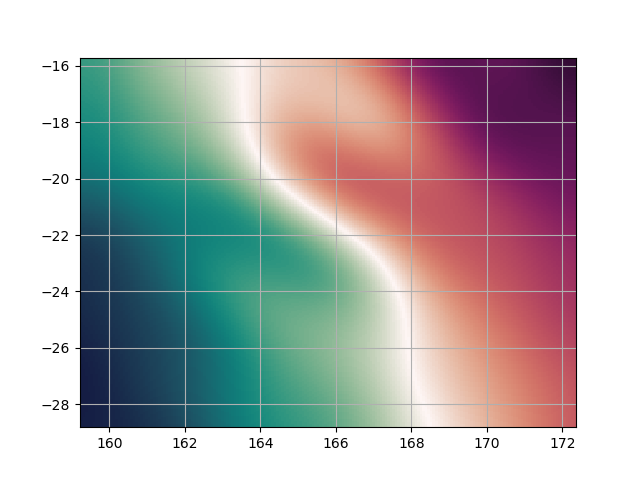

In [10]:
geo_filtered = np.array([griddata(
    np.array([ENSLAT2D.flatten(), ENSLON2D.flatten()]).T,  
    cart_ssh_filtered.flatten(),                        
    (lat2d, lon2d),                                       
    method='cubic'                                         
)])


ssh_bar = xr.DataArray(
    data=geo_filtered[0], 
    dims=["lat", "lon"],   # Dimensions
    #coords={"lat": lat2d[:, 0], "lon": lon2d[0, :]},  # Coordinates
    coords={"lat": lat2d[:, 0], "lon": lon2d[0, :]},  # Coordinates
    name="geo_filtered"  # Name 
)

plt.figure()
plt.pcolormesh(ssh_bar.lon, ssh_bar.lat, ssh_bar, cmap=cmocean.cm.curl)
plt.grid(True, which='both')
plt.show()